In [80]:
from selenium import webdriver
from selenium.webdriver.edge.service import Service
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import Select

import pandas as pd
import numpy as np
import pickle
import os
import sys
import warnings
import time

from bs4 import BeautifulSoup
import requests
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}


from selenium.webdriver.edge.options import Options

edge_options = Options()
#edge_options.add_argument('--headless')
edge_options.add_argument("--disable-images")  # Disable images
edge_options.add_argument("--disable-javascript")  # Disable JavaScript
edge_options.add_argument("--disable-plugins")  # Disable plugins
edge_options.add_argument("--disable-extensions")  # Disable extensions
edge_options.add_argument("--blink-settings=imagesEnabled=false")  # Another image disabling flag


# Set a minimal User-Agent (like a text-only browser)
edge_options.add_argument("user-agent=Links (2.25; Linux 2.4.24)")

driver = webdriver.Edge(service=Service('msedgedriver.exe'), options=edge_options)
#driver.execute_cdp_cmd("Network.setBlockedURLs", {"urls": ["*.jpg", "*.png", "*.gif","*.svg"]})
#driver.execute_cdp_cmd("Network.enable", {})


driver.maximize_window()

driver.execute_script("document.body.style.zoom='67%'")

In [ ]:
url='https://www.imdb.com/search/title/?title_type=tv_series&user_rating=8,10&num_votes=10000,&sort=user_rating,desc'
driver.get(url)

In [ ]:
scroll_count=0

while True:
    try:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        next_page_button=WebDriverWait(driver,10).until(expected_conditions.element_to_be_clickable((By.CSS_SELECTOR, 'span[class="ipc-btn__text"] span[class="ipc-see-more__text"]')))
        driver.execute_script('arguments[0].click();', next_page_button)
        scroll_count+=1
        print(scroll_count,end='\r')
    except:
        break



In [ ]:
tv_urls=[e.get_attribute('href') for e in driver.find_elements(By.CSS_SELECTOR, 'ul[role="presentation"] li[class="ipc-metadata-list-summary-item"] a[class="ipc-title-link-wrapper"]')]

In [ ]:
tv_urls=list(set(tv_urls))

In [ ]:
len(tv_urls)

In [ ]:
tv_urls=[str(i).split('?')[0]+'ratings' for i in tv_urls]

In [ ]:
def convert_to_float(episode):
    try:
        return float(episode)
    except:
        return None

In [ ]:
all_data=[]

for index, tv_url in enumerate(tv_urls,start=1):
    driver.get(tv_url)
    time.sleep(2)

    tv=driver.find_element(By.CSS_SELECTOR, 'h2[data-testid="subtitle"]').text
    try:
        seasons=[e.text for e in WebDriverWait(driver,10).until(expected_conditions.visibility_of_all_elements_located((By.CSS_SELECTOR, 'table[data-testid="heatmap__episode-data"] tbody tr')))]
    except:
        continue
    season_ratings={}
    all_episode_ratings=[]
    for i, season in enumerate(seasons,start=1):
        episodes=season.split('\n')
        espisode_ratings = [r for r in (convert_to_float(ep) for ep in episodes) if r is not None]
        season_rating=round(sum(espisode_ratings)/len(espisode_ratings),2) if len(espisode_ratings)>0 else None
        season_ratings[f'S{i}']=season_rating
        all_episode_ratings.extend(espisode_ratings)

    data_dict={'URL':tv_url, 'Title':tv, 'Season Ratings':season_ratings, 'All Episode Ratings':all_episode_ratings}
    all_data.append(data_dict)

    print(f'{index}/{len(tv_urls)}',end='\r')


In [81]:
#pickle.dump(all_data, open('all_data.pickle','wb'))
all_data=pickle.load( open('all_data.pickle','rb'))

In [82]:
df=pd.DataFrame(all_data)

In [83]:
ratings_df=pd.json_normalize(df['Season Ratings'])
df=pd.concat([df[['URL','Title']],ratings_df,df['All Episode Ratings']],axis=1)

In [84]:
df

,URL,Title,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,All Episode Ratings
0,https://www.imdb.com/title/tt0106052/ratings,Late Night with Conan O'Brien,6.70,5.60,8.50,NaN,7.00,5.05,2.25,NaN,NaN,5.60,6.00,5.42,4.33,7.60,NaN,"[7.5, 6.8, 6.1, 6.4, 5.6, 8.5, 7.0, 4.0, 6.1, ..."
1,https://www.imdb.com/title/tt8289930/ratings,Formula 1: Drive to Survive,7.81,7.90,7.81,7.28,7.21,7.39,7.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[7.8, 7.7, 8.2, 8.1, 7.5, 7.8, 7.6, 8.1, 7.6, ..."
2,https://www.imdb.com/title/tt2384811/ratings,Utopia,8.32,8.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[8.4, 8.1, 8.3, 8.0, 8.3, 8.8, 9.1, 8.5, 8.5, ..."
3,https://www.imdb.com/title/tt5024912/ratings,Insecure,7.69,7.70,7.75,7.95,7.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[7.3, 7.2, 7.5, 7.7, 7.6, 7.8, 8.1, 8.3, 7.9, ..."
4,https://www.imdb.com/title/tt0080306/ratings,Yes Minister,8.17,8.26,8.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[8.0, 8.1, 8.0, 8.8, 8.2, 8.2, 7.9, 8.4, 8.3, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843,https://www.imdb.com/title/tt1190634/ratings,The Boys,8.55,8.55,8.62,7.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[8.7, 8.5, 8.3, 8.7, 8.3, 8.1, 8.7, 9.1, 8.1, ..."
844,https://www.imdb.com/title/tt0214341/ratings,Dragon Ball Z,7.72,7.90,8.04,8.14,7.40,7.97,7.84,7.69,7.62,7.22,7.34,7.68,7.87,7.79,7.57,"[7.8, 8.0, 8.1, 8.1, 7.8, 7.5, 7.5, 7.3, 7.4, ..."
845,https://www.imdb.com/title/tt0237123/ratings,Coupling,8.67,8.57,8.60,7.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[8.2, 8.5, 8.7, 9.0, 9.0, 8.6, 9.0, 8.4, 8.5, ..."
846,https://www.imdb.com/title/tt0094525/ratings,Poirot,7.32,7.51,7.56,8.00,7.64,7.85,7.60,7.70,8.03,7.60,7.70,7.85,7.96,NaN,NaN,"[7.6, 7.4, 6.9, 7.2, 7.6, 7.4, 7.3, 7.1, 7.0, ..."


In [85]:
ratings_df

,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15
0,6.70,5.60,8.50,NaN,7.00,5.05,2.25,NaN,NaN,5.60,6.00,5.42,4.33,7.60,NaN
1,7.81,7.90,7.81,7.28,7.21,7.39,7.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8.32,8.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7.69,7.70,7.75,7.95,7.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8.17,8.26,8.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843,8.55,8.55,8.62,7.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
844,7.72,7.90,8.04,8.14,7.40,7.97,7.84,7.69,7.62,7.22,7.34,7.68,7.87,7.79,7.57
845,8.67,8.57,8.60,7.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
846,7.32,7.51,7.56,8.00,7.64,7.85,7.60,7.70,8.03,7.60,7.70,7.85,7.96,NaN,NaN


In [86]:
all_remove_indexes=[]

for i in ratings_df.index:
    row=ratings_df.loc[i]
    values=[v for v in row]

    indexes=[]
    for j, v in enumerate(values):
        if pd.isna(v):
            indexes.append(j)

    remove_indexes=set()
    for j in range(len(indexes)):
        if j>0:
            if indexes[j]-indexes[j-1]>1:
                remove_indexes.add(i)
    all_remove_indexes.extend(remove_indexes)

In [87]:
all_remove_indexes

[0, 161, 344, 619]

In [88]:
df=df.drop(all_remove_indexes)

In [89]:
ratings_df=df[df.columns[df.columns.str.startswith('S')]]

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

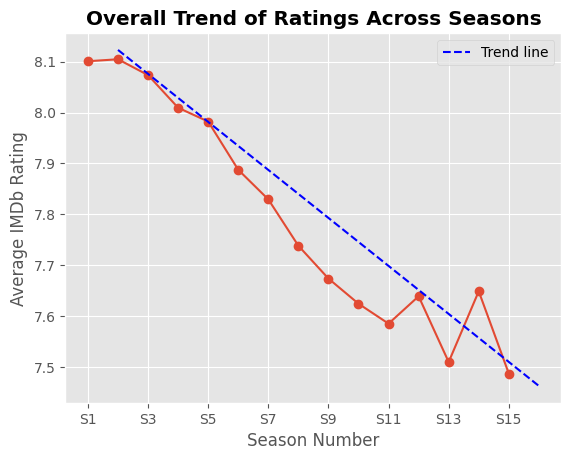

In [91]:
seasons_sorted=range(1,len(ratings_df.columns)+1)
means_sorted=ratings_df.mean(axis=0).values

ratings_df.mean(axis=0).plot.line(marker='o')
plt.xlabel('Season Number')
plt.ylabel('Average IMDb Rating')
plt.title('Overall Trend of Ratings Across Seasons',fontweight='bold')
plt.grid(True)

coeffs = np.polyfit(seasons_sorted, means_sorted, deg=1)
trend_line = np.poly1d(coeffs)
plt.plot(seasons_sorted, trend_line(seasons_sorted), linestyle='--', color='blue', label='Trend line')
plt.legend()

plt.show()

In [92]:
changes_df=[]
for row in range(ratings_df.shape[0]):
    changes_row=[]
    for col in range(ratings_df.shape[1]):
        if col!=ratings_df.shape[1]-1:

            first_value=ratings_df.iloc[row, col]
            second_value=ratings_df.iloc[row, col+1]
            change=(second_value-first_value)/first_value

        changes_row.append(change)
    changes_df.append(changes_row)

In [93]:
changes_df=pd.DataFrame(changes_df)

In [94]:
changes_df.columns=[f'S{i}-S{i+1}' for i in range(1,16,1)]

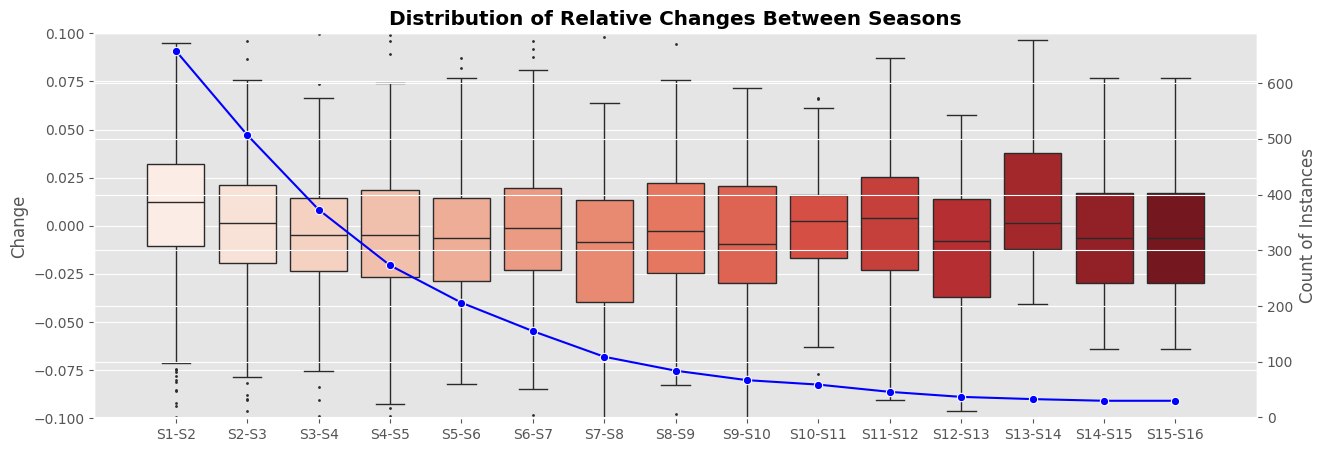

In [95]:
fig, ax = plt.subplots(figsize=(15,5))
ax2 = ax.twinx()
sns.boxplot(data=changes_df, palette='Reds', flierprops=dict(marker='o', markersize=1), ax=ax)
sns.lineplot(x=changes_df.columns, y=changes_df.notna().sum(), color='Blue', marker='o', ax=ax2)
ax.set_ylim(-0.1, 0.1)
ax.set_title("Distribution of Relative Changes Between Seasons", fontweight='bold')
ax.set_ylabel('Change')
ax2.set_ylabel('Count of Instances')
plt.show()